# Import

In [52]:
import pandas as pd
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split     ## import train & test splitting library from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB   ,BernoulliNB , MultinomialNB  ## Bernoulli Naive Bayes
from sklearn.metrics import f1_score, recall_score
import joblib
import re
import numpy as np

# Read

In [2]:
df = pd.read_json("./thai_sentiment_dataset.json")
df = df.drop_duplicates()

In [3]:
df.sample(5)

,story,sentiment
8175,อังเก้ ปอสเตโคกลู ผู้จัดการทีมของท็อตแนม ฮอตสเ...,positive
8900,“เต๋า สมชาย” โคตรตื่นเต้น “น้องสุขใจ” เล่นละคร...,positive
5810,วันนี้ ( 7 พ.ย.66 ) เวลา 10.50 น. ณ บริเวณโถงก...,positive
26816,"กรุงศรีนคร, นิวเซาท์เวลส์ วันที่ 6 พฤศจิกายน 2...",neutral
2307,นายประสิทธิ์ บุญดวงประเสริฐ ประธานคณะผู้บริหาร...,positive


# ดูอัตราส่วน label
ค่อนข้างเท่ากันจึงไม่ downsample

<Axes: xlabel='sentiment'>

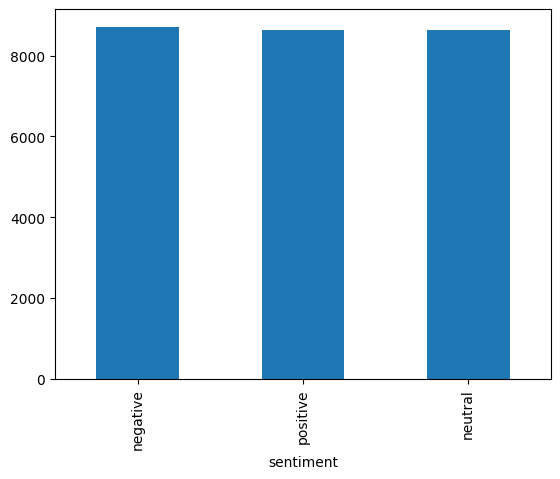

In [4]:
df['sentiment'].value_counts().plot.bar()

# Cleaning
remove everything else except word with length > 1

In [5]:

stopwords = list(thai_stopwords())
print(len(stopwords))
def text_process(text):                                          ###  split word and text preprocessing
    final = re.sub(r'[^a-zA-Z\sก-๛]', '', text, flags=re.UNICODE)
    final = "".join(u for u in final if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split() if word.lower() not in stopwords and len(word) > 1)
    return final.lower()

1030


In [6]:
df['text_tokens'] = df['story'].apply(text_process)
df

# Extract feature by countvectorizer

In [7]:
count_vector = CountVectorizer(token_pattern="[\S]+")
#count_vector = TfidfVectorizer(token_pattern="[\S]+",smooth_idf=True,use_idf=True)

Y = df['sentiment']
X = df['text_tokens']
X = count_vector.fit_transform(X)   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print("Vocab size " ,len(count_vector.vocabulary_))

Vocab size  65786


In [8]:
vocab = list(count_vector.vocabulary_.items())      # For furthur inspection in jupyter
print(len(count_vector.vocabulary_))

65786


# Naive bay model test

In [15]:
clf = MultinomialNB()
clf.fit(X_train, Y_train)
acc = clf.score(X_test,Y_test)
print("Accuracy on test : ",acc)

Accuracy on test :  0.6416073831955393


# LogisticRegression model test

In [16]:
softmax_regression_model = LogisticRegression(multi_class='multinomial',max_iter=1000000,n_jobs=4)
softmax_regression_model.fit(X_train, Y_train)
acc2 = softmax_regression_model.score(X_test,Y_test)
print("Accuracy on test : ",acc2)

Accuracy on test :  0.7392809075177851


# Hyper parameter tuning on RandomForestClassifier

In [17]:
param_grid = {
    'n_estimators': [50,100,150,200,250],
    'max_depth': [50, 75, 100, 125, 150, 175,200],
    'max_features': ["sqrt",None]
}

# Initialize the RandomForestClassifier
forest_model = RandomForestClassifier(random_state=1, verbose=1, n_jobs=4)

# Initialize RandomizedSearchCV with the custom scorer
# This already do cross validation on given data!
tuner = GridSearchCV(estimator=forest_model, param_grid=param_grid, verbose=2,n_jobs=4)

# Fit the tuner on the training data
tuner.fit(X_train, Y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 30.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 44.1min finished
[Parallel(n_jobs=4)]: Us

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   40.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   40.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Para

[CV] END ...max_depth=50, max_features=sqrt, n_estimators=50; total time=  40.5s
[CV] END ...max_depth=50, max_features=sqrt, n_estimators=50; total time=  42.1s
[CV] END ..max_depth=50, max_features=sqrt, n_estimators=100; total time= 1.4min
[CV] END ..max_depth=50, max_features=sqrt, n_estimators=150; total time= 2.1min
[CV] END ..max_depth=50, max_features=sqrt, n_estimators=200; total time= 2.8min
[CV] END ..max_depth=50, max_features=sqrt, n_estimators=250; total time= 3.4min
[CV] END ..max_depth=50, max_features=sqrt, n_estimators=250; total time= 3.5min
[CV] END ...max_depth=50, max_features=None, n_estimators=50; total time=10.3min
[CV] END ..max_depth=50, max_features=None, n_estimators=100; total time=21.7min
[CV] END ..max_depth=50, max_features=None, n_estimators=150; total time=32.9min
[CV] END ..max_depth=50, max_features=None, n_estimators=200; total time=43.1min
[CV] END ..max_depth=50, max_features=None, n_estimators=200; total time=41.1min
[CV] END ..max_depth=50, max

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 14.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 30.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 |

In [44]:
# Results
print("Best parameters:", tuner.best_params_)
print("Best score on val data:", tuner.best_score_)
cv_result = pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")
cv_result

Best parameters: {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 250}
Best score on val data: 0.7412019230769231


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,351.390142,3.157790,1.187189,0.040277,100,sqrt,250,"{'max_depth': 100, 'max_features': 'sqrt', 'n_...",0.752404,0.742788,0.732452,0.740385,0.737981,0.741202,0.006567,1
23,278.481731,3.119909,0.912934,0.101153,100,sqrt,200,"{'max_depth': 100, 'max_features': 'sqrt', 'n_...",0.751923,0.745433,0.730288,0.739904,0.735577,0.740625,0.007531,2
22,210.772928,2.625752,0.805607,0.028774,100,sqrt,150,"{'max_depth': 100, 'max_features': 'sqrt', 'n_...",0.752163,0.741587,0.732933,0.738462,0.737740,0.740577,0.006422,3
44,412.072198,18.021735,1.226442,0.041940,150,sqrt,250,"{'max_depth': 150, 'max_features': 'sqrt', 'n_...",0.752163,0.741587,0.739423,0.736298,0.732452,0.740385,0.006644,4
14,296.378019,3.350330,1.144790,0.044927,75,sqrt,250,"{'max_depth': 75, 'max_features': 'sqrt', 'n_e...",0.754808,0.741346,0.730769,0.734615,0.740144,0.740337,0.008182,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1902.803887,63.336400,0.749633,0.069909,50,None,150,"{'max_depth': 50, 'max_features': None, 'n_est...",0.735096,0.728846,0.727404,0.730529,0.717308,0.727837,0.005865,66
10,61.288129,0.686658,0.362821,0.010247,75,sqrt,50,"{'max_depth': 75, 'max_features': 'sqrt', 'n_e...",0.733413,0.730288,0.726442,0.722837,0.725962,0.727788,0.003676,67
6,1307.126868,84.054543,0.703355,0.289581,50,None,100,"{'max_depth': 50, 'max_features': None, 'n_est...",0.731971,0.726923,0.723798,0.730529,0.715625,0.725769,0.005818,68
5,630.944179,9.682292,0.337718,0.026389,50,None,50,"{'max_depth': 50, 'max_features': None, 'n_est...",0.733894,0.723558,0.714663,0.727163,0.715144,0.722885,0.007314,69


# Create model from tuned parameter

In [48]:
final_model = RandomForestClassifier(n_jobs=4, max_depth=tuner.best_params_["max_depth"], max_features=tuner.best_params_["max_features"], n_estimators=tuner.best_params_["n_estimators"])
final_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=100, n_estimators=250, n_jobs=4)

# Accuracy measure

In [50]:
y_pred = final_model.predict(X_test)
f1 = f1_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
print("f1",f1,"recall",recall)

f1 0.7714675555030016 recall 0.7714820460594544


# Train with entire dataset

In [51]:
final_model.fit(X,Y)

RandomForestClassifier(max_depth=100, n_estimators=250, n_jobs=4)

## Save and wait for actual test data

In [54]:
joblib.dump(final_model, "./random_forest.joblib",compress=3)

['./random_forest.joblib']